In [1]:
from espuma import Case_Directory, Boundary_Probe
from espuma.base import Dict_File
from espuma_utils import to_numeric

import pyvista as pv
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
from pprint import pprint

try:
    NOTEBOOK_NAME = __file__
except NameError:
    NOTEBOOK_NAME = __vsc_ipynb_file__ #noqa: F821 #type: ignore


In [2]:
pv.set_jupyter_backend('static')
pv.start_xvfb()

plt.style.use('./matplotlib_style/edwin.mplstyle')

In [3]:
## Clone case from the template
of_case = Case_Directory("CASES_fit_experimental/rhox_0010__kappa_1.00e-11")

In [4]:
## Create mesh
of_case._blockMesh()

## Quick snapshot of the computational domain
reader= of_case.get_vtk_reader()
mesh = reader.read()
internalMesh = mesh['internalMesh']

blockMesh finished successfully!


In [5]:
xmin, xmax, ymin, ymax, zmin, zmax = internalMesh.bounds
ypad = -0.03

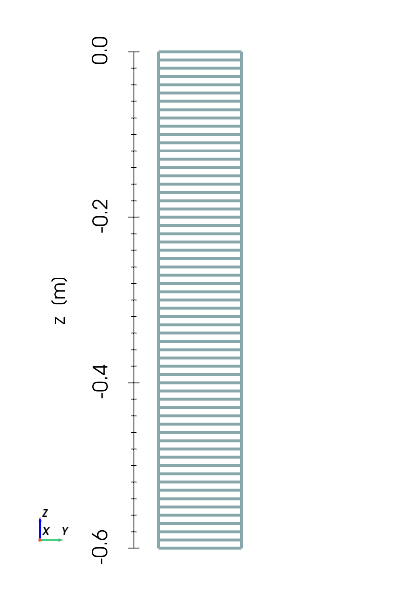

In [6]:
plotter = pv.Plotter()
plotter.add_mesh(internalMesh.scale([1,0.5,1]).translate((0,0,-0.6)), style="wireframe", line_width=3, edge_color="black")
plotter.window_size = (400, 600)
plotter.view_yz()
plotter.enable_parallel_projection()
plotter.show_axes()
plotter.show_bounds(
    show_xaxis=False,
    show_yaxis=False,
    show_zaxis=True,
    show_xlabels=False,
    show_ylabels=False,
    show_zlabels=True,
    n_zlabels=4,
    # location='closest',
    color='black',
    bold=False,
    font_size=12,
    # grid='front',
    ztitle="z  [m]",
    ticks='both',
    minor_ticks=True,
    bounds=[xmin, xmax, ymin + ypad, ymax, zmin-0.6, zmax-0.6],
    axes_ranges=[xmin, xmax, ymin + ypad, ymax, zmin-0.6, zmax-0.6]
)
plotter.zoom_camera(1.30)
plotter.show()

In [7]:
soil_parameters_dirpath = Path(of_case.constant.path / "soilParameters")
soil_parameters = {}

for f in soil_parameters_dirpath.iterdir():
    if not f.suffix:
        dict_file = Dict_File(f)
        s = dict_file["internalField"]
        soil_parameters[f.name] = to_numeric(s)

pprint(soil_parameters)

{'K_0': 0.0002067,
 'Sw_r': 0.0312,
 'Sw_s': 1.0,
 'alpha': 2.79,
 'nRef': 0.385,
 'n_vangenucthen': 7.26}


In [8]:
α = soil_parameters['alpha']
n = soil_parameters['n_vangenucthen']
m = 1 - 1 / n
θs = soil_parameters['Sw_s'] * soil_parameters['nRef']
θr = soil_parameters['Sw_r'] * soil_parameters['nRef']
porosity = soil_parameters['nRef']
Ks = soil_parameters['K_0']

def vanGenuchten(h: np.array) -> np.array:
    θe = np.where(h >= 0, 1.0, np.power(1 + np.power(α * h * np.sign(h), n), -m))
    return θe


def waterSaturation(h: np.array) -> np.array:
    θe = vanGenuchten(h)
    θ = θe * (θs - θr) + θr
    return θ


def mualemPermeability(h: np.array) -> np.array:
    θe = vanGenuchten(h)
    kr = np.sqrt(θe) * np.power(1 - np.power(1 - np.power(θe, 1 / m), m), 2)
    return kr


def capillarity(h) -> np.array:
    x = np.where(
        h >= 0,
        0.0,
        α
        * m
        * n
        * np.power(α * h * np.sign(h), n - 1)
        * np.power(1 + np.power(α * h * np.sign(h), n), -m - 1),
    )
    x *= θs - θr
    return x

In [9]:
h = np.concatenate([np.linspace(-10, -1.0e-3, 500), np.linspace(0, 0.5, 10)])
θe = vanGenuchten(h)
θ = waterSaturation(h)
kr = mualemPermeability(h)
Ch = capillarity(h)

In [10]:
def theta2sw(theta: float) -> float:
    return theta / porosity

def sw2theta(sw: float) -> float:
    return sw * porosity

def cm_min2m_s(cm_per_min:float):
    return cm_per_min / 100 / 60

def m_s2cm_min(m_per_s:float):
    return m_per_s * 100 * 60

In [11]:
print(f"{m_s2cm_min(Ks) = } cm/min")

m_s2cm_min(Ks) = 1.2402 cm/min


In [12]:
from matplotlib.ticker import SymmetricalLogLocator, LogLocator
import matplotlib as mpl

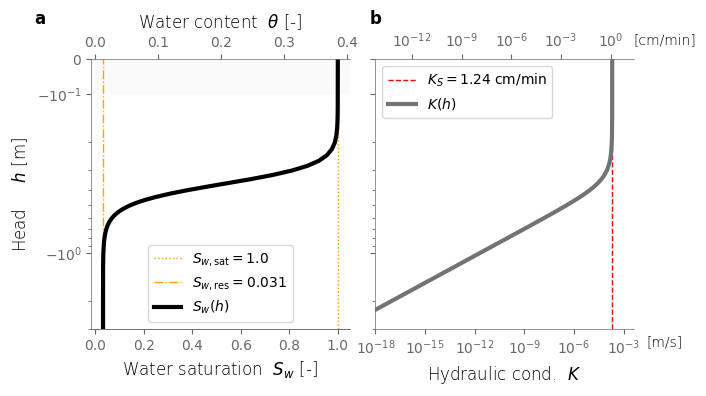

In [13]:
with mpl.rc_context({'axes.labelsize':12}):
    fig, axs = plt.subplots(1,2, figsize=[7, 3.5], sharey=True, gridspec_kw={'wspace':0.1})

    linthersh = 0.1
    ax = axs[0]
    ax.axhspan(-linthersh, linthersh, alpha=0.02)

    ax.axvline(x=θs, ls="dotted", lw=1, c="darkorange", label=rf"$S_{{w,{{\rm sat}}}}={theta2sw(θs):.1f}$")
    ax.axvline(x=θr, ls="dashdot", lw=1, c="orange", label=rf"$S_{{w,{{\rm res}}}}={theta2sw(θr):.3f}$")
    ax.plot(θ, h, label=r"$S_w(h)$", lw=3)
    ax.xaxis.set_label_position('top') 
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.spines.top.set_visible(True)
    ax.set_xlabel(R"Water content  $\theta$ [-]")
    ax.set_ylabel("Head \t $h$ [m]")
    ax.set_ylim(-3, 0)
    ax.set_yscale("symlog", linthresh=linthersh, linscale=0.2)
    secax = ax.secondary_xaxis('bottom', functions=(theta2sw, sw2theta))
    secax.set_xlabel("Water saturation  $S_w$ [-]")
    secax.set_xlim(0, 1)

    ax.tick_params(which='both', axis='y')
    ax.yaxis.set_minor_locator(SymmetricalLogLocator(base=10, linthresh=linthersh, subs=[i for i in range(10)]))
    ax.legend(prop={'size':10})

    ax = axs[1]
    ax.axvline(Ks, ls="dashed", lw=1, c="red", label=Rf"$K_S = {m_s2cm_min(Ks):.2f}$ cm/min")

    ax.plot(kr * Ks, h, label=r"$K(h)$", lw=3, c="0.45")
    ax.set_xscale('log')
    ax.set_xlabel('Hydraulic cond.  $K$')
    ax.set_xlim(1e-18, 20*Ks)
    ax.legend(prop={'size':10})
    ax.text(1., 1.07,R"[cm/min]", ha='left', va='center', transform=ax.transAxes, clip_on=False, weight=100)
    ax.text(1.05, -0.05,R"[m/s]", ha='left', va='center', transform=ax.transAxes, clip_on=False, weight=100)

    secax = ax.secondary_xaxis('top', functions=(m_s2cm_min, cm_min2m_s))
    secax.xaxis.set_minor_locator(LogLocator(base=10, subs ='all'))

    axs[0].set_title('a', x=-0.2, y=1.1, weight=700)
    axs[1].set_title('b', x=0, y=1.1, weight=700)

    plt.savefig(
        f"plots/{NOTEBOOK_NAME.rpartition('/')[-1].removesuffix('.ipynb')}(water_content_curve).pdf", 
        format="pdf", bbox_inches='tight', pad_inches=0.05
    )

    plt.show()